In [ ]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf

## **마운트 설정**

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = ""
project_dir = "HAI 2.0"

base_path = Path("/content/drive/My Drive/Colab Notebooks/data")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 디렉토리 위치: /content/drive/My Drive/Colab Notebooks/data/HAI 2.0


## **데이터 불러오기**

In [ ]:
# 환경별로 상이 할 수 있습니다. 디렉토리 주소를 잘 참조하세요

from pathlib import Path

current_path = Path().absolute()
training_data_path = current_path / "training"
validation_data_path=current_path/ "validation"
test_data_path=current_path/"testing"

TRAIN_DATASET = sorted([x for x in Path(training_data_path).glob("*.csv")])
TEST_DATASET = sorted([x for x in Path(test_data_path).glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path(validation_data_path).glob("*.csv")])

def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
VALIDATION_DF_RAW=dataframe_from_csvs(VALIDATION_DATASET)

In [ ]:


columns= TRAIN_DF_RAW.columns.drop("time")
train_min = TRAIN_DF_RAW[columns].min()
train_max = TRAIN_DF_RAW[columns].max()
def normalize(df):
    ndf = df.copy()
    
    for c in df.columns:
        if train_min[c] == train_max[c]:
            ndf[c] = df[c] - train_min[c]
        else:
            ndf[c] = (df[c] - train_min[c]) / (train_max[c] - train_min[c])
    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

train = normalize(TRAIN_DF_RAW[columns])
boundary_check(train)

## validation data set

columns_val=VALIDATION_DF_RAW.columns.drop(["time","attack"])

validation=normalize(VALIDATION_DF_RAW[columns_val])

## **Train data 파악하기**

In [ ]:
train_notime=train.copy()

train_all=train.copy()
train_all["time"]=TRAIN_DF_RAW["time"]

Normalization 완료 후 time 컬럼 추가로 Concat

In [ ]:
train_all

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,time
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,0.481272,0.260132,0.200820,0.0,0.478068,0.357101,0.881536,0.0,0.0,0.270592,0.0,0.0,0.045701,0.708779,0.0,0.406877,0.289495,0.0,0.317237,0.139665,0.983325,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661946,0.0,1.0,0.215404,0.0,0.642237,0.373146,0.444904,0.465909,0.0,0.392405,0.047904,0.0,0.0,0.574348,1.0,0.206193,0.996286,0.049420,0.000870,0.0,0.996286,0.0,0.480318,0.0,0.0,0.0,0.189004,0.0,0.989609,0.808081,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254,2020-07-11 00:00:00
1,0.378459,0.0,0.0,0.226548,0.351630,0.000154,0.400309,0.359799,0.795139,0.543787,0.517171,0.246802,0.200820,0.0,0.476524,0.357101,0.888848,0.0,0.0,0.264089,0.0,0.0,0.042571,0.709256,0.0,0.406877,0.289765,0.0,0.316404,0.139665,0.984469,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661431,0.0,1.0,0.232863,0.0,0.551026,0.377049,0.574404,0.522727,0.0,0.405063,0.043627,0.0,0.0,0.576815,1.0,0.207052,0.993659,0.048721,0.000609,0.0,0.993659,0.0,0.451108,0.0,0.0,0.0,0.188535,0.0,0.989609,0.808081,0.592759,0.0,0.326835,0.254278,0.337838,0.916661,0.266530,0.250469,1.00000,0.506623,2020-07-11 00:00:01
2,0.378459,0.0,0.0,0.226810,0.314829,0.000154,0.392647,0.461334,0.804977,0.538611,0.496060,0.252053,0.200922,0.0,0.479610,0.357101,0.911883,0.0,0.0,0.262481,0.0,0.0,0.039023,0.709324,0.0,0.404259,0.289765,0.0,0.315852,0.139665,0.982944,0.326923,0.0,0.0,0.0,1.0,0.0,0.482697,0.661090,0.0,1.0,0.251605,0.0,0.449923,0.377439,0.693722,0.655303,0.0,0.392405,0.040205,0.0,0.0,0.577754,1.0,0.206049,0.991429,0.048721,0.000609,0.0,0.991429,0.0,0.456287,0.0,0.0,0.0,0.187396,0.0,0.989609,0.878788,0.595906,0.0,0.326338,0.255413,0.337838,0.916661,0.265099,0.255028,1.00000,0.464946,2020-07-11 00:00:02
3,0.378953,0.0,0.0,0.226810,0.229915,0.000154,0.393743,0.309032,0.814815,0.450733,0.479229,0.247947,0.200820,0.0,0.479610,0.357101,0.923035,0.0,0.0,0.265487,0.0,0.0,0.035476,0.709596,0.0,0.408186,0.289495,0.0,0.307291,0.139665,0.988280,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.655771,0.0,1.0,0.260847,0.0,0.324038,0.380952,0.827156,0.560606,0.0,0.392405,0.037639,0.0,0.0,0.574348,1.0,0.206205,0.992024,0.048721,0.000348,0.0,0.992024,0.0,0.508270,0.0,0.0,0.0,0.186994,0.0,0.989609,0.848485,0.596221,0.0,0.326338,0.257590,0.331076,0.916661,0.264281,0.252816,1.00000,0.443695,2020-07-11 00:00:03
4,0.380435,0.0,0.0,0.226810,0.157685,0.000154,0.414918,0.690968,0.824074,0.319543,0.511626,0.245254,0.200922,0.0,0.476524,0.357101,0.935101,0.0,0.0,0.260803,0.0,0.0,0.032555,0.709256,0.0,0.405568,0.289765,0.0,0.308395,0.139665,0.989805,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.656459,0.0,1.0,0.281900,0.0,0.281736,0.382514,0.781466,0.541667,0.0,0.417722,0.035073,0.0,0.0,0.576815,1.0,0.207645,0.991231,0.049071,0.000348,0.0,0.991231,0.0,0.456890,0.0,0.0,0.0,0.186488,0.0,0.989609,0.919192,0.599053,0.0,0.326835,0.256196,0.337838,0.916661,0.262577,0.247117,1.00000,0.480956,2020-07-11 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.0,0.0,0.703684,0.510313,0.000538,0.415518,0.335006,0.064236,0.649781,0.522814,0.477447,0.362090,0.0,0.857438,0.215741,0.000914,0.0,0.0,0.310726,0.0,0.0,0.747913,0.777293,0.0,0.836387,0.520929,0.0,0.379924,0.067039,0.976084,0.271635,0.0,0.0,0.0,1.0,0.0,0.946227,0.328480,0.0,1.0,0.001027,0.0,0.833236,0.482045,0.541112,0.643939,0.0,0.417722,0.749358,0.0,0.0,0.585389,1.0,0.7349

In [ ]:
train_notime.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
count,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.0,921603.0,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.000000,921603.0,921603.000000,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000
mean,0.465165,0.0,0.0,0.449502,0.354876,0.270435,0.441053,0.477264,0.332229,0.418924,0.509883,0.502522,0.575737,0.0,0.693048,0.430722,0.215338,0.0,0.0,0.369736,0.0,0.0,0.391521,0.565814,0.0,0.655291,0.413507,0.156214,0.401785,0.282963,0.563509,0.328306,0.0,0.0,0.0,0.605251,0.0,0.737377,0.417851,0.0,0.547057,0.172878,0.0,0.571308,0.430411,0.540039,0.574660,0.156214,0.441822,0.396807,0.0,0.0,0.581593,0.550005,0.451519,0.619043,0.145575,0.409127,0.0,0.619042,0.0,0.475294,0.0,0.0,0.0,0.566801,0.0,0.883730,0.798310,0.636090,0.297275,0.332980,0.382692,0.439215,0.279265,0.372062,0.378616,0.402974,0.617261
std,0.151090,0.0,0.0,0.229977,0.145387,0.407312,0.065465,0.098656,0.371094,0.179270,0.015976,0.225650,0.320490,0.0,0.216865,0.197470,0.325361,0.0,0.0,0.129502,0.0,0.0,0.362803,0.296545,0.0,0.229714,0.104895,0.363058,0.122871,0.223657,0.444207,0.042752,0.0,0.0,0.0,0.421813,0.0,0.263877,0.150935,0.0,0.434133,0.295487,0.0,0.182462,0.055965,0.226514,0.085060,0.363058,0.065809,0.365693,0.0,0.0,0.023867,0.432729,0.231758,0.421302,0.229118,0.402168,0.0,0.421304,0.0,0.069641,0.0,0.0,0.0,0.316497,0.0,0.249355,0.241589,0.054825,0.452754,0.040240,0.111186,0.258283,0.352598,0.129857,0.140328,0.258098,0.136340
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.392787,0.0,0.0,0.199112,0.246341,0.000384,0.396321,0.410567,0.005208,0.269305,0.499562,0.323549,0.260656,0.0,0.490636,0.343433,0.001280,0.0,0.0,0.295483,0.0,0.0,0.002296,0.325478,0.0,0.416230,0.302727,0.000000,0.331011,0.100557,0.032301,0.329327,0.0,0.0,0.0,0.121543,0.0,0.496236,0.315705,0.0,0.133634,0.001284,0.0,0.420177,0.388368,0.334760,0.526515,0.000000,0.392405,0.005133,0.0,0.0,0.579399,0.139909,0.202872,0.118855,0.047669,0.000000,0.0,0.118855,0.0,0.428988,0.0,0.0,0.0,0.257105,0.0,0.950263,0.636364,0.605032,0.000000,0.317842,0.268152,0.229730,0.083339,0.297750,0.286337,0.261620,0.526546
50%,0.461957,0.0,0.0,0.509538,0.349759,0.000922,0.449082,0.486423,0.136574,0.419144,0.509485,0.498182,0.558299,0.0,0.798428,0.443247,0.005850,0.0,0.0,0.364634,0.0,0.0,0.335351,0.599196,0.0,0.766813,0.461788,0.000000,0.397435,0.215082,0.866222,0.334135,0.0,0.0,

In [ ]:
train["C01"].std()

0.15109021647131887

In [ ]:
#std가 0 인 컬럼 파악하기

std0list=[]
for c in train_notime.columns:
  colstd=train[c].std()
  if colstd==0.0:
    std0list.append(c)
print(std0list)

['C02', 'C03', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C61', 'C63', 'C64', 'C65', 'C67']


## **시계열 그래프 그리기 (각 컬럼별)**



In [ ]:
#time colum str->datetime으로 overloading
train_all['time']=pd.to_datetime(train_all["time"])


In [33]:
#train data는 크게 3개의 시계열 덩이로 나타나있습니다. 전체를 다 보려면 train_all을 변수로 보면 됩니다.

firstset=train_all[train_all['time']<'2020-07-13']
secondset=train_all[(train_all['time']>'2020-07-13') & (train_all['time']<'2020-08-04')]
thirdset=train_all[train_all['time']>'2020-08-04']

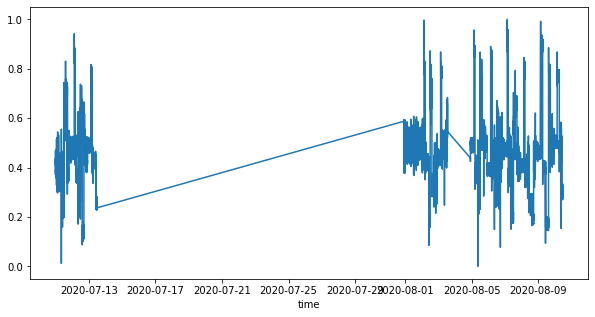

In [34]:
import datetime
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#전체보기
x1 = train_all["time"]
y1 = train_all["C01"]

#부분보기

#x1 = firstset["time"]
#y1= firstset['C04']


# plot
plt.plot(x1,y1)

#아래 코드들을 추가하면 겹쳐서 볼 수 있습니다.
#plt.plot(x1,y2)
#plt.plot(x1,y3)

#plot option
plt.rcParams["figure.figsize"] = (10,5)

plt.xlabel('time')
plt.show()

## **Validation data set 파악**

In [ ]:
validation_notime=validation.copy()
validation_all=validation.copy()
validation_notime["attack"]=VALIDATION_DF_RAW['attack']
validation_all[['attack','time']]=VALIDATION_DF_RAW[['attack','time']]
validation_all['time']=pd.to_datetime(validation_all['time'])

In [ ]:
validation_all.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
count,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.0,43201.0,43201.000000,43201.0,43201.0,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.0,43201.0,43201.0,43201.000000,43201.0,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.0,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.0,43201.000000,43201.0,43201.000000,43201.0,43201.0,43201.0,43201.000000,43201.0,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000,43201.000000
mean,0.426533,0.001679,0.0,0.497971,0.458110,0.234134,0.453634,0.449229,0.328822,0.429076,0.509876,0.506590,0.671235,0.0,0.739857,0.374390,0.217993,0.0,0.0,0.367932,0.0,0.0,0.409868,0.546804,0.0,0.703841,0.459849,0.413856,0.406960,0.311131,0.599239,0.326573,0.0,0.0,0.0,0.630823,0.0,0.796276,0.416856,0.0,0.560744,0.170445,0.0,0.374177,0.447100,0.427336,0.615383,0.413856,0.454439,0.415366,0.0,0.0,0.581642,0.563550,0.502785,0.656844,0.152668,0.428233,0.0,0.656840,0.0,0.493005,0.0,0.0,0.0,0.661808,0.0,0.989758,0.799743,0.650675,0.263001,0.331700,0.433241,0.462180,0.960013,0.370248,0.376794,0.403148,0.360160,0.014560
std,0.090843,0.056417,0.0,0.212861,0.121228,0.387183,0.115872,0.095789,0.367010,0.159385,0.016105,0.223959,0.310838,0.0,0.167842,0.065378,0.328793,0.0,0.0,0.122726,0.0,0.0,0.360561,0.292647,0.0,0.184516,0.111118,0.492529,0.115004,0.230435,0.434478,0.046979,0.0,0.0,0.0,0.401306,0.0,0.200011,0.125136,0.0,0.422549,0.290626,0.0,0.178934,0.061701,0.228078,0.183746,0.492529,0.116298,0.363486,0.0,0.0,0.024476,0.421747,0.215533,0.406889,0.221398,0.401300,0.0,0.406893,0.0,0.067528,0.0,0.0,0.0,0.308159,0.0,0.006710,0.243562,0.053762,0.436398,0.045563,0.119513,0.274859,0.245237,0.122685,0.133880,0.203251,0.156172,0.119784
min,0.096838,0.000000,0.0,-0.074471,0.149534,0.000000,-2.114028,0.025974,0.000000,0.034139,0.372215,0.032449,-0.126025,0.0,-0.197692,0.313259,-0.000548,0.0,0.0,0.031464,0.0,0.0,0.000000,0.005925,0.0,-0.167712,0.000000,0.000000,0.092515,0.000000,0.000286,-0.257212,0.0,0.0,0.0,0.000000,0.0,0.410998,0.112696,0.0,0.000076,-0.000770,0.0,-0.020585,0.000781,-0.200780,-3.431818,0.000000,-2.126582,0.000000,0.0,0.0,0.366103,0.000000,-0.080786,0.001052,0.001052,0.000000,0.0,0.001052,0.0,0.207682,0.0,0.0,0.0,-0.118378,0.0,0.979634,0.090909,0.000000,0.000000,-0.244380,-0.080969,0.013515,0.833321,0.035583,0.037007,0.179704,0.006390,0.000000
25%,0.379941,0.000000,0.0,0.323752,0.375998,0.000230,0.428046,0.384888,0.007523,0.282512,0.499562,0.326108,0.344365,0.0,0.677367,0.328929,0.000914,0.0,0.0,0.296322,0.0,0.0,0.006887,0.291494,0.0,0.626765,0.394815,0.000000,0.339906,0.117317,0.065936,0.329327,0.0,0.0,0.0,0.220813,0.0,0.720857,0.314552,0.0,0.142354,0.001027,0.0,0.231988,0.421936,0.215327,0.571970,0.000000,0.430380,0.009410,0.0,0.0,0.579399,0.149177,0.322342,0.242618,0.048019,0.000000,0.0,0.242618,0.0,0.447338,0.0,0.0,0.0,0.339573,0.0,0.987947,0.666667,0.632094,0.000000,0.317344,0.362875,0.243240,0.888881,0.298637,0.284929,0.179704,0.259396,0.000000
50%,0.398222,0.000000,0.0,0.513718,0.455506,0.000615,0.458684,0.459563,0.133102,0.433416,0.509485,0.504107,0.779918,0.0,0.783719,0.328929,0.006947,0.0,0.0,0.367501,0.0,0.0,0.415067,0.576789,0.0,0.749798,0.491493,0.000000,0.406476,0.262570,0.9

# **Validationset 중 std가 0인 것들**

In [36]:

std0list_val=[]
for c in validation.columns:
  colstd=train[c].std()
  if colstd==0.0:
    std0list_val.append(c)
print(std0list_val)

['C02', 'C03', 'C14', 'C18', 'C19', 'C21', 'C22', 'C25', 'C33', 'C34', 'C35', 'C37', 'C40', 'C43', 'C51', 'C52', 'C59', 'C61', 'C63', 'C64', 'C65', 'C67']


## **Validation data set 그래프 그리기**

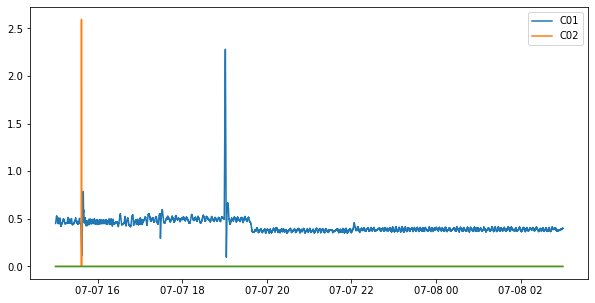

In [ ]:
# make up some data
valset=validation_all

#x축 시간으로 고정
x1 = valset["time"]


#y축은 normalized이미 되었습니다.
# 확인하고 싶은 컬럼 y#=valset[{컬럼명}] 형식으로 추가하세요
y1 = valset["C01"]
y2 = valset["C02"]
y3= valset['C03']
#y4= valset[컬럼명]

# plot
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.plot(x1,y3)
#plt.plot(x1,y#) 이 부분에 원하는 컬럼 넣으면 됩니다.

#plt 설정
plt.rcParams["figure.figsize"] = (100,5)
plt.legend(['C01','C02'])
plt.xlabel('time')
plt.show()

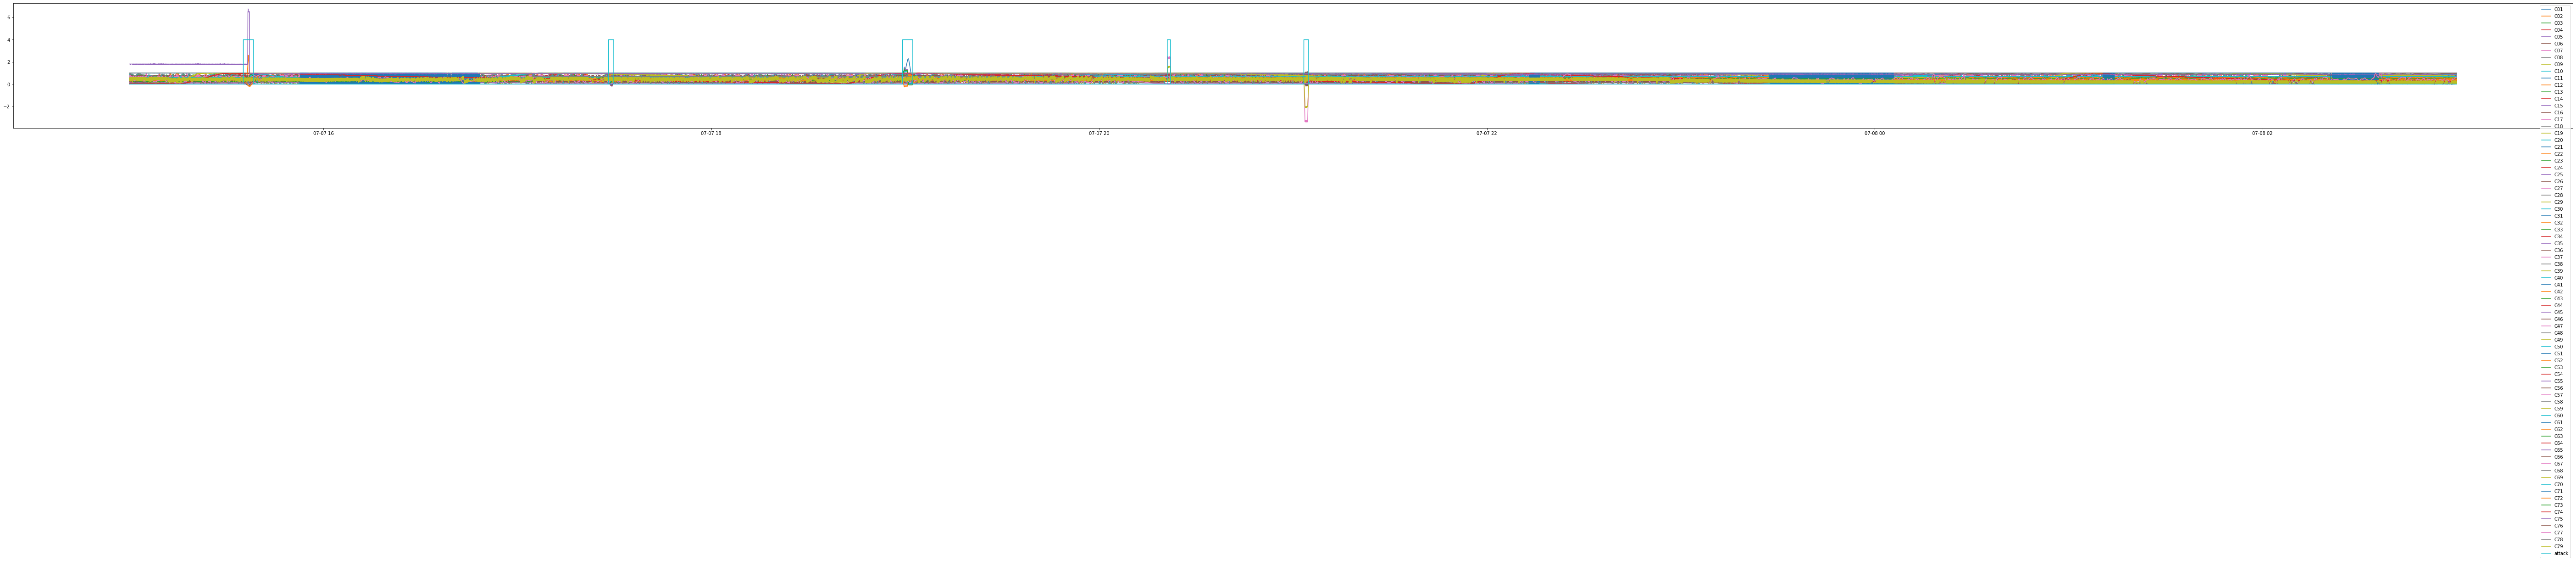

In [ ]:
#Validation data 컬럼 모두 그래프에 나타내기

valset_notime=validation_all.columns.drop("time")

#범례
legend_list=[]

for k in list(valset_notime):
   if k =='attack':
     continue
   y=k
   plt.plot(x1,validation_notime[k])
   legend_list.append(k)


#attack부분 *4해서 표기하기
valset_attack=validation_all.copy()
valset_attack['attack']=valset_attack['attack']*4

#attack 표시
plt.plot(x1,valset_attack['attack'])
legend_list.append('attack')

#plot 설정
plt.rcParams["figure.figsize"] = (100,5)
plt.legend(legend_list)
plt.show()


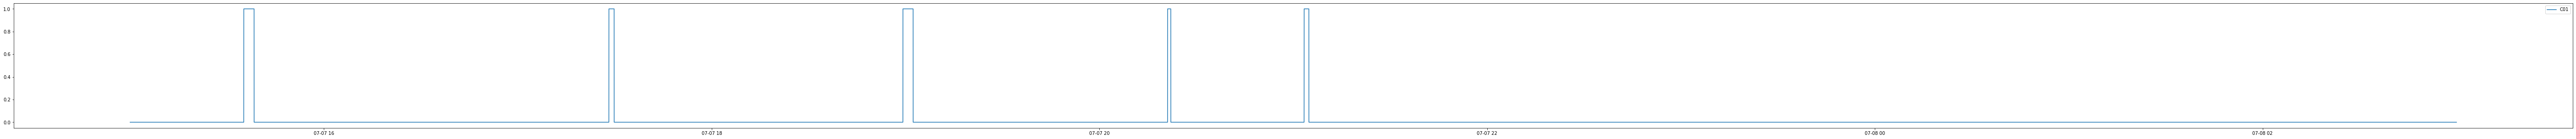

In [ ]:
# attack 부분만 표시한 것
plt.plot(x1,validation_all['attack'])

plt.rcParams["figure.figsize"] = (100,5)
plt.legend(legend_list)
plt.show()

Seaborn 라이브러리 써서 추가 예정입니다.


0822 안지훈